# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [91]:
import torch
import numpy as np
from typing import Sequence, List, Tuple
import graphviz
from matplotlib import colormaps, colors

In [139]:
cat = np.linspace(0.1, 1, 6)
colormaps.get_cmap('viridis')(cat[0])

(0.282623, 0.140926, 0.457517, 1.0)

## Automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)

In [2]:
from __future__ import annotations
from collections import UserString

class TIndex:
    def __init__(self, name):
        self.__index_name = name
    
    @property
    def name(self):
        return self.__index_name
    
    def __eq__(self, __value: TIndex | str) -> bool:
        if isinstance(__value, str):
            return self.__index_name == __value
        return self.__index_name == __value.name
    
    def __str__(self) -> str:
        return self.__index_name
    
    def __repr__(self) -> str:
        return 'TIndex: ' + self.__index_name
    
    def _repr_markdown_(self):
        return f'**{self.__repr__()}**'
    
    def _repr_html_(self):
        return f'<b style="color:#be00d9; font-family: verdana, sans-serif;">{self.__repr__()}</b>'
    
class TTNIndex:
    def __init__(self, layer: int, layer_index: int):

        self.__layer = layer
        self.__layer_index = layer_index
        self.__name = f"{layer}.{layer_index}"

        self.__indices = [TIndex(f"{layer+1}.{2*layer_index}"), TIndex(f"{layer+1}.{2*layer_index+1}"), TIndex(f"{layer}.{layer_index}")]

    def __getitem__(self, key: int) -> TIndex:
        return self.__indices[key]
    
    def __setitem__(self, key: int, value: TIndex):
        self.__indices[key] = value
    
    @property
    def name(self):
        return self.__name 

    @property
    def indices(self):
        return self.__indices
    
    @indices.setter
    def indices(self, value):
        self.__indices = value

    def __eq__(self, __value: TTNIndex | str):
        if isinstance(__value, str):
            return self.__name == __value
        return self.__name == __value.name
    
    def __hash__(self):
        return hash(self.__name)
    
    def __str__(self) -> str:
        return f"{self.__layer}.{self.__layer_index}"
    
    def __repr__(self) -> str:
        return f"TTNIndex: {self.__layer}.{self.__layer_index}"
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#0088d9; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for tindex in self.__indices:
            markdown_str += f'&emsp;&ensp; {tindex._repr_html_()}<br>'
        return markdown_str + '</details>'

In [3]:
TTNIndex(5,1)

TTNIndex: 5.1

In [165]:
class TTN:
    def __init__(
        self,
        n_features,
        n_phys=2,
        n_labels=2,
        label_tag="label",
        bond_dim=4,
        dtype=torch.cdouble,
        device="cpu",
    ):
        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")

        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_labels   = n_labels
        self.label_tag  = label_tag
        self.bond_dim   = bond_dim
        self.device     = device

        self.__dtype    = dtype
        self.__n_layers = int(np.log2(n_features))
        self.__tensors  = []
        self.__indices  = np.asarray([TTNIndex(l, i) for l in range(self.__n_layers) for i in range(2**l)])
        self.__indices[0][2] = TIndex(label_tag)

        self.__initialized = False
        self.__id = np.zeros([self.bond_dim] * 3, dtype=np.float64)
        for i in range(self.__id.shape[0]):
            self.__id[i, i, i] = 1.0

        

        # add first tensor with special index
        if not (self.__n_layers - 1):
            self.__tensors.append(
                torch.rand(
                    size=(self.n_phys, self.n_phys, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )
        else:
            dim = min(self.n_phys ** (self.__n_layers), self.bond_dim)
            self.__tensors.append(
                torch.rand(
                    size=(dim, dim, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )

        for l in range(1, self.__n_layers - 1):  # constructing the ttn starting from the top
            dim_pre = min(self.n_phys ** (self.__n_layers - l), self.bond_dim)
            dim_post = min(self.n_phys ** (self.__n_layers - l + 1), self.bond_dim)
            self.__tensors.extend(
                [
                    torch.rand(
                        size=[dim_pre] * 2 + [dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    if np.random.rand() < 0.5
                    else torch.as_tensor(
                        data=self.__id[:dim_pre, :dim_pre, :dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    for i in range(2**l)
                ]
            )

        dim = min(self.n_phys**2, self.bond_dim)
        self.__tensors.extend(
            [
                torch.rand(
                    size=[self.n_phys] * 2 + [dim],
                    dtype=self.__dtype,
                    device=self.device
                )
                for i in range(2 ** (self.__n_layers - 1))
            ]
        )

        self.__tensor_map = dict(zip(self.__indices, self.__tensors))
    
    def __getitem__(self, key: Sequence[TTNIndex | str] | str | int | slice) -> dict[TTNIndex, torch.Tensor]:

        if isinstance(key, int):
            return {self.__indices[key]: self.__tensor_map[self.__indices[key]]}
        elif isinstance(key, str):
            return {self.__indices[self.__indices==key].item(): self.__tensor_map[key]}
        elif isinstance(key, Sequence):
            return {k if isinstance(k, TTNIndex) else self.__indices[self.__indices==k].item(): self.__tensor_map[k] for k in key}
        elif isinstance(key, slice):
            return {k: self.__tensor_map[k] for k in self.__indices[key]}
        else:
            raise TypeError(f"Invalid argument type: {type(key)}")
        
    def __repr__(self) -> str:
        return f"TTN"
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#d95100; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for tindex in self.__indices:
            markdown_str += f'{tindex._repr_html_()}'
        return markdown_str + '</details>'
    
    def draw(self, name='TTN', cmap='Pastel1'):
        cmap = colormaps.get_cmap(cmap)
        categories = np.linspace(0.1, 1, self.__n_layers)
        dot = graphviz.Digraph(name, comment='TTN: ' + name, format='svg',graph_attr={'bgcolour': 'transparent', 'rankdir': 'BT', 'splines':'false'})
        dot.attr('node', shape='circle', fixedsize='true', width='0.5', regular='true')
        dot.attr('edge', color='#bfbfbf')

        for tindex in self.__indices:
            dot.attr('node', fillcolor=colors.rgb2hex(cmap(categories[int(tindex.name.split('.')[0])])), style='filled')
            dot.node(tindex.name, tindex.name)
            dot.edge(tindex[0].name, tindex.name, label=tindex[0].name)
            dot.edge(tindex[1].name, tindex.name, label=tindex[1].name)
        return dot

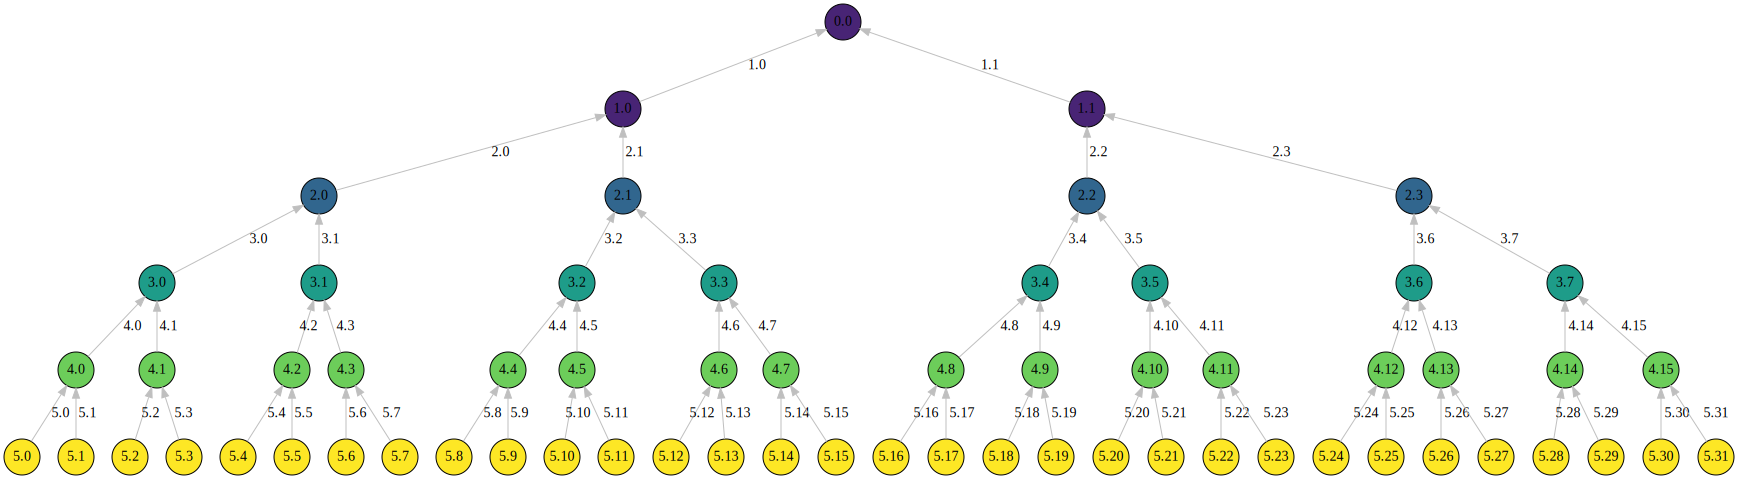

In [168]:
ttn = TTN(32)
ttn.draw(cmap='viridis')